In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

Gaussian Process toy example (Latent f2 and posterior predictive for y)

Fit a Gaussian Process (GP) $y_{std} = GP(0, k(x, x'))$ with $k(x, x')$ a RBF kernel\
We add some Gaussian nose using $N(0, \sigma_y^2)$ to mimic randomness and model noise\
GP samples new predictions with mean and variance\
assume known $f_1$: ``exp_f2_mean = np.exp(f2_mean)``

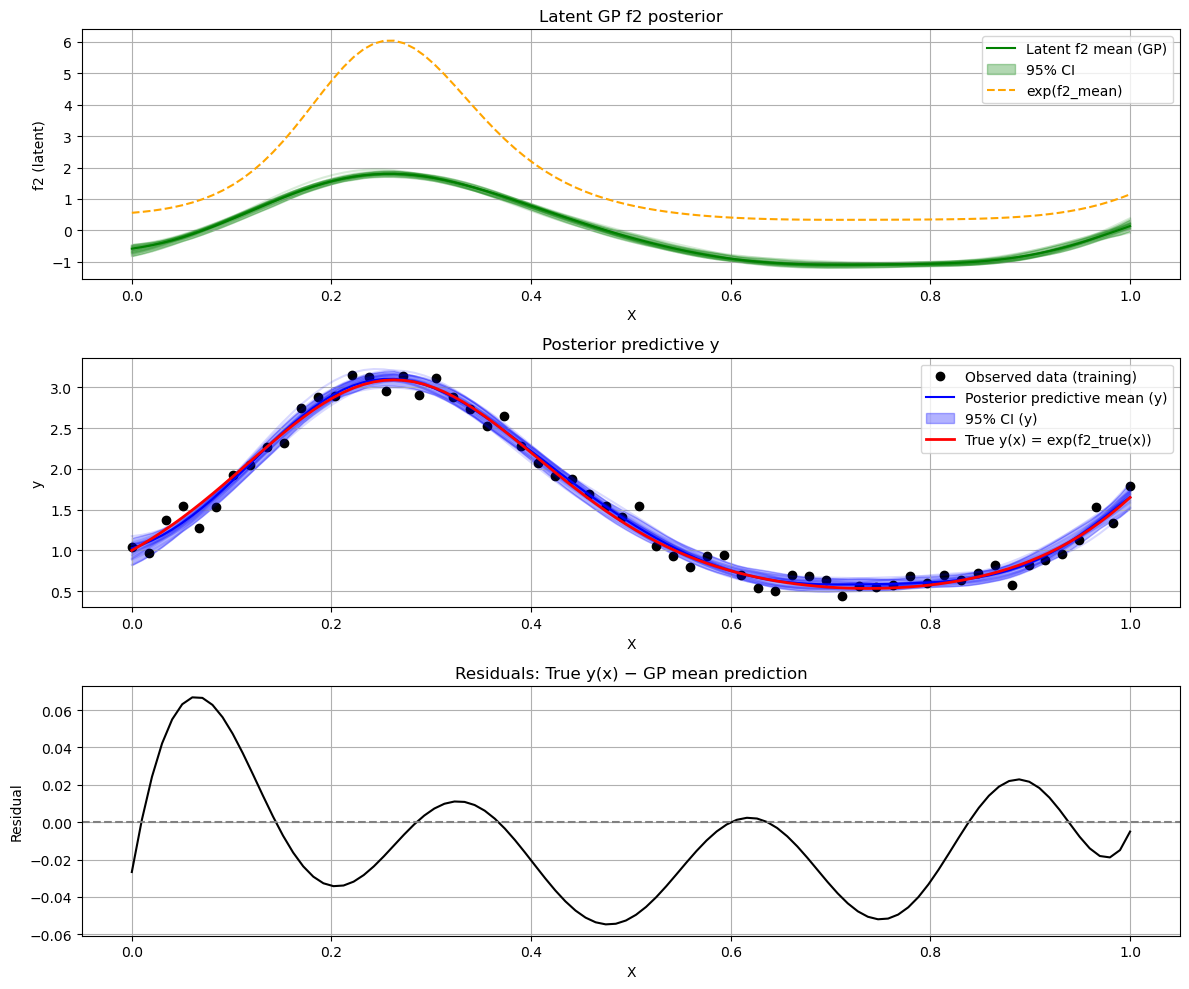

In [30]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)

n = 60
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

# Standardize y for predictive rescaling later
y_train_mean = y.mean()
y_train_std = y.std()
y_std = (y - y_train_mean) / y_train_std

# -------------------------
# 2. Fit a Gaussian Process
# -------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5,
                              alpha=sigma_y**2, normalize_y=True)
gp.fit(X, y_std)

# -------------------------
# 3. Predict on new points
# -------------------------
X_star = np.linspace(0, 1, 100).reshape(-1, 1)  # prediction inputs
y_mean_std, y_cov = gp.predict(X_star, return_cov=True)
y_std_samples = np.random.multivariate_normal(y_mean_std, y_cov, size=50)

# Rescale to original y
y_mean = y_mean_std * y_train_std + y_train_mean
y_post = y_std_samples * y_train_std + y_train_mean
y_lo, y_hi = np.percentile(y_post, [2.5, 97.5], axis=0)

# -------------------------
# 4. Latent f2 approximation
# (for demonstration, using same GP as latent)
# -------------------------
f2_mean = y_mean_std
f2_post = y_std_samples
f2_lo, f2_hi = np.percentile(f2_post, [2.5, 97.5], axis=0)
exp_f2_mean = np.exp(f2_mean)

# -------------------------
# 5. Compute true functions and metrics
# -------------------------
X_pred_flat = X_star.flatten()
f2_true_vals = f2_true(X_pred_flat)
y_true_vals = f1(f2_true_vals)

r2_y = r2_score(y_true_vals, y_mean)
r2_f2 = r2_score(f2_true_vals, f2_mean)

# -------------------------
# 6. Plot latent f2 and posterior predictive y (with true functions)
# -------------------------
n_samples_to_plot = min(20, y_post.shape[0], f2_post.shape[0])

plt.figure(figsize=(12, 10))

# --- Top: latent f2 ---
ax1 = plt.subplot(3, 1, 1)
ax1.plot(X_pred_flat, f2_mean, color='green', label="Latent f2 mean (GP)")
ax1.fill_between(X_pred_flat, f2_lo, f2_hi, color='green', alpha=0.3, label="95% CI")
for i in np.random.choice(f2_post.shape[0], n_samples_to_plot, replace=False):
    ax1.plot(X_pred_flat, f2_post[i], color='green', alpha=0.15)
ax1.plot(X_pred_flat, exp_f2_mean, color='orange', linestyle='--', label="exp(f2_mean)")
# ax1.plot(X_pred_flat, f2_true_vals, color='red', linewidth=2, label="True f2(x)")
# ax1.plot(X_pred_flat, np.exp(f2_true_vals), color='red', linestyle='--', linewidth=2, label="True exp(f2(x))")
ax1.set_xlabel("X")
ax1.set_ylabel("f2 (latent)")
ax1.set_title(f"Latent GP f2 posterior")
ax1.legend()
ax1.grid(True)

# --- Middle: posterior predictive y ---
ax2 = plt.subplot(3, 1, 2)
ax2.plot(X.flatten(), y, 'o', color='black', label="Observed data (training)")
ax2.plot(X_pred_flat, y_mean, color='blue', label="Posterior predictive mean (y)")
ax2.fill_between(X_pred_flat, y_lo, y_hi, color='blue', alpha=0.3, label="95% CI (y)")
for i in np.random.choice(y_post.shape[0], n_samples_to_plot, replace=False):
    ax2.plot(X_pred_flat, y_post[i], color='blue', alpha=0.15)
ax2.plot(X_pred_flat, y_true_vals, color='red', linewidth=2, label="True y(x) = exp(f2_true(x))")
ax2.set_xlabel("X")
ax2.set_ylabel("y")
ax2.set_title(f"Posterior predictive y")
ax2.legend()
ax2.grid(True)

# --- Bottom: residuals ---
ax3 = plt.subplot(3, 1, 3)
ax3.plot(X_pred_flat, y_true_vals - y_mean, 'k', lw=1.5)
ax3.axhline(0, color='gray', linestyle='--')
ax3.set_title("Residuals: True y(x) − GP mean prediction")
ax3.set_xlabel("X")
ax3.set_ylabel("Residual")
ax3.grid(True)

plt.tight_layout()
plt.show()


GP Composition f1(f2(x))

Instead of one GP as before, we use now a composition of two GP's\
1st GP learns f2 again and second GP learns a map from the latent outputs to the final output $z \rightarrow f_1(z)$\
This procedure only makes sense, if we don't know the outer function f1\
No uncertainty propagation in this model

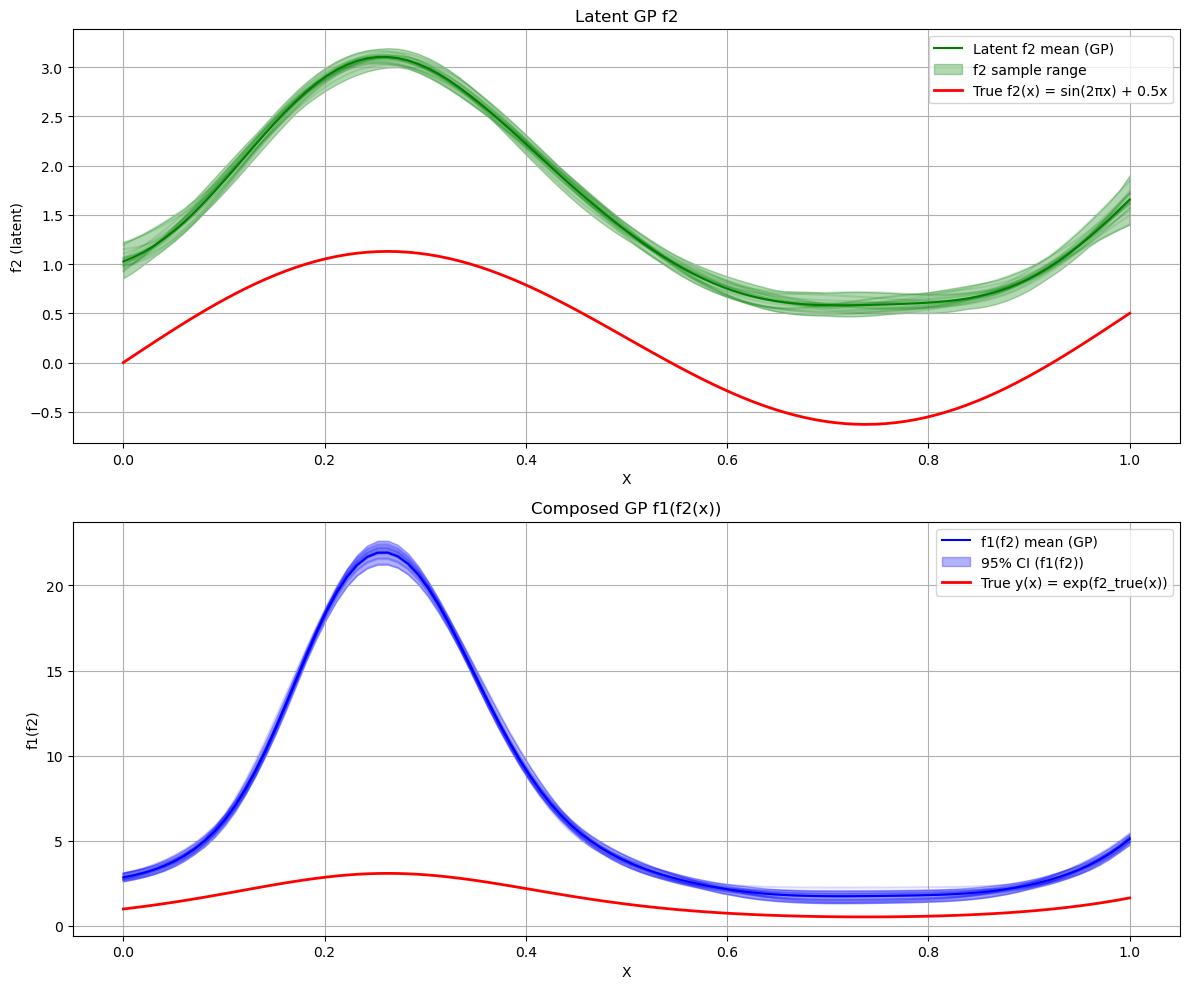

In [ ]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)

n = 60
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

# Standardize y for GP
y_train_mean = y.mean()
y_train_std = y.std()
y_std = (y - y_train_mean) / y_train_std

# -------------------------
# 2. Fit first GP (f2)
# -------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.2, length_scale_bounds=(1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=sigma_y**2, normalize_y=True)
gp_f2.fit(X, y_std)

X_star = np.linspace(0, 1, 100).reshape(-1, 1)
f2_mean_std, f2_cov = gp_f2.predict(X_star, return_cov=True)
f2_samples_std = np.random.multivariate_normal(f2_mean_std, f2_cov, size=50)

# Rescale f2 to original y-scale
f2_mean = f2_mean_std * y_train_std + y_train_mean
f2_samples = f2_samples_std * y_train_std + y_train_mean

# -------------------------
# 3. Compose second GP (f1(f2))
# -------------------------
# Use known f1 on GP mean as targets for f1 GP
f1_targets = f1(f2_mean)
gp_f1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=sigma_y**2, normalize_y=True)
gp_f1.fit(f2_mean.reshape(-1,1), f1_targets)

# Predict f1(f2(x))
f1_mean, f1_cov = gp_f1.predict(f2_mean.reshape(-1,1), return_cov=True)
f1_samples = np.random.multivariate_normal(f1_mean, f1_cov, size=50)
f1_lo, f1_hi = np.percentile(f1_samples, [2.5, 97.5], axis=0)

# -------------------------
# 4. Plotting (with true functions)
# -------------------------
n_samples_to_plot = min(20, f2_samples.shape[0], f1_samples.shape[0])
X_pred_flat = X_star.flatten()

# Compute true functions
f2_true_vals = f2_true(X_pred_flat)
f1_true_vals = f1(f2_true_vals)

plt.figure(figsize=(12, 10))

# --- Top: latent f2 ---
ax1 = plt.subplot(2,1,1)
ax1.plot(X_pred_flat, f2_mean, color='green', label="Latent f2 mean (GP)")
ax1.fill_between(X_pred_flat, f2_samples.min(axis=0), f2_samples.max(axis=0),
                 color='green', alpha=0.3, label="f2 sample range")
for i in np.random.choice(f2_samples.shape[0], n_samples_to_plot, replace=False):
    ax1.plot(X_pred_flat, f2_samples[i], color='green', alpha=0.15)
# True latent function
ax1.plot(X_pred_flat, f2_true_vals, color='red', linewidth=2, label="True f2(x) = sin(2πx) + 0.5x")
ax1.set_xlabel("X")
ax1.set_ylabel("f2 (latent)")
ax1.set_title("Latent GP f2")
ax1.legend()
ax1.grid(True)

# --- Bottom: f1(f2(x)) ---
ax2 = plt.subplot(2,1,2)
ax2.plot(X_pred_flat, f1_mean, color='blue', label="f1(f2) mean (GP)")
ax2.fill_between(X_pred_flat, f1_lo, f1_hi, color='blue', alpha=0.3, label="95% CI (f1(f2))")
for i in np.random.choice(f1_samples.shape[0], n_samples_to_plot, replace=False):
    ax2.plot(X_pred_flat, f1_samples[i], color='blue', alpha=0.15)
# True composed function
ax2.plot(X_pred_flat, f1_true_vals, color='red', linewidth=2, label="True y(x) = exp(f2_true(x))")
ax2.set_xlabel("X")
ax2.set_ylabel("f1(f2)")
ax2.set_title("Composed GP f1(f2(x))")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



GP for f2 reconstruction followed by a NN for f1 approximation

NN inputs: f2 values (GP mean) targets f1(f2(z))

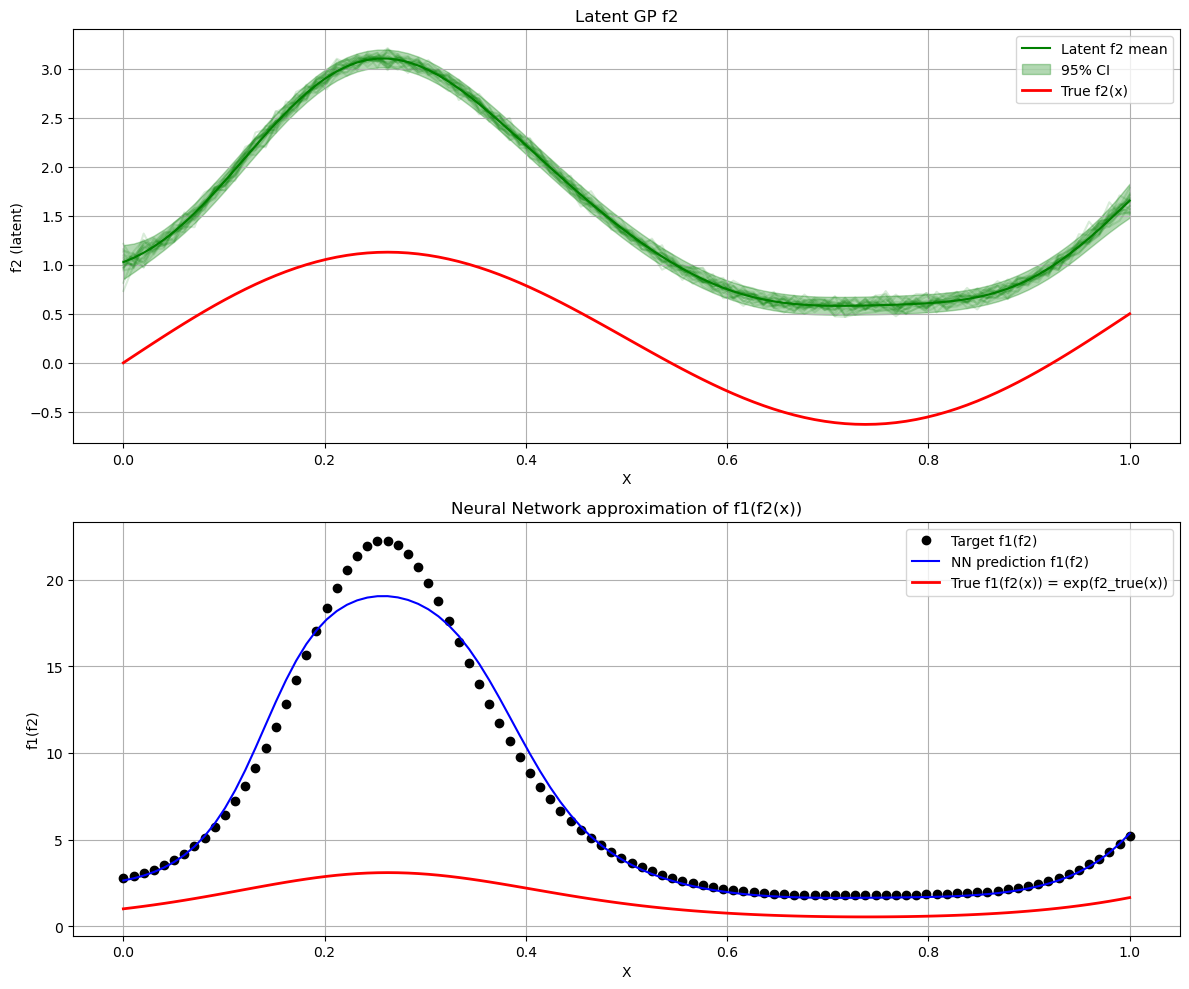

In [ ]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)

n = 60
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

# -------------------------
# 2. Fit GP for f2(x)
# -------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.2, length_scale_bounds=(1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=sigma_y**2, normalize_y=True)
gp_f2.fit(X, y)

X_star = np.linspace(0, 1, 100).reshape(-1, 1)
f2_mean, f2_std = gp_f2.predict(X_star, return_std=True)

# Generate MC samples for uncertainty visualization
f2_samples = np.array([f2_mean + f2_std*np.random.randn(len(f2_mean)) for _ in range(50)])

# -------------------------
# 3. Fit Neural Network for f1(f2)
# -------------------------
# Use known f1 on GP mean as targets
f1_targets = f1(f2_mean)

# Convert to torch tensors
f2_tensor = torch.tensor(f2_mean.reshape(-1,1), dtype=torch.float32)
f1_tensor = torch.tensor(f1_targets.reshape(-1,1), dtype=torch.float32)

# Define a tiny NN
class TinyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TinyNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(f2_tensor)
    loss = loss_fn(pred, f1_tensor)
    loss.backward()
    optimizer.step()

# NN predictions
f1_mean_nn = model(f2_tensor).detach().numpy()

# -------------------------
# 4. Plot results
# -------------------------
X_pred_flat = X_star.flatten()
n_samples_to_plot = min(20, f2_samples.shape[0])
# True functions
f2_true_vals = f2_true(X_pred_flat)
f1_true_vals = f1(f2_true_vals)

plt.figure(figsize=(12, 10))

# Top: latent f2
ax1 = plt.subplot(2,1,1)
ax1.plot(X_pred_flat, f2_mean, color='green', label="Latent f2 mean")
ax1.fill_between(X_pred_flat, f2_mean - 1.96*f2_std, f2_mean + 1.96*f2_std, color='green', alpha=0.3, label="95% CI")
for i in np.random.choice(f2_samples.shape[0], n_samples_to_plot, replace=False):
    ax1.plot(X_pred_flat, f2_samples[i], color='green', alpha=0.15)
ax1.plot(X_pred_flat, f2_true_vals, color='red', linewidth=2, label="True f2(x)")
ax1.set_xlabel("X")
ax1.set_ylabel("f2 (latent)")
ax1.set_title("Latent GP f2")
ax1.legend()
ax1.grid(True)

# Bottom: f1(f2(x)) using NN
ax2 = plt.subplot(2,1,2)
ax2.plot(X_pred_flat, f1_targets, 'o', color='black', label="Target f1(f2)")
ax2.plot(X_pred_flat, f1_mean_nn, color='blue', label="NN prediction f1(f2)")
ax2.plot(X_pred_flat, f1_true_vals, color='red', linewidth=2, label="True f1(f2(x)) = exp(f2_true(x))")
ax2.set_xlabel("X")
ax2.set_ylabel("f1(f2)")
ax2.set_title("Neural Network approximation of f1(f2(x))")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Compositional GP for a known f1 and learn a latent f2

f2 is unknown, learn iit using a GP and invert the relationship to $f_2^{pseudo} = log(y)$\
latent GP regression istead of stacked GP's

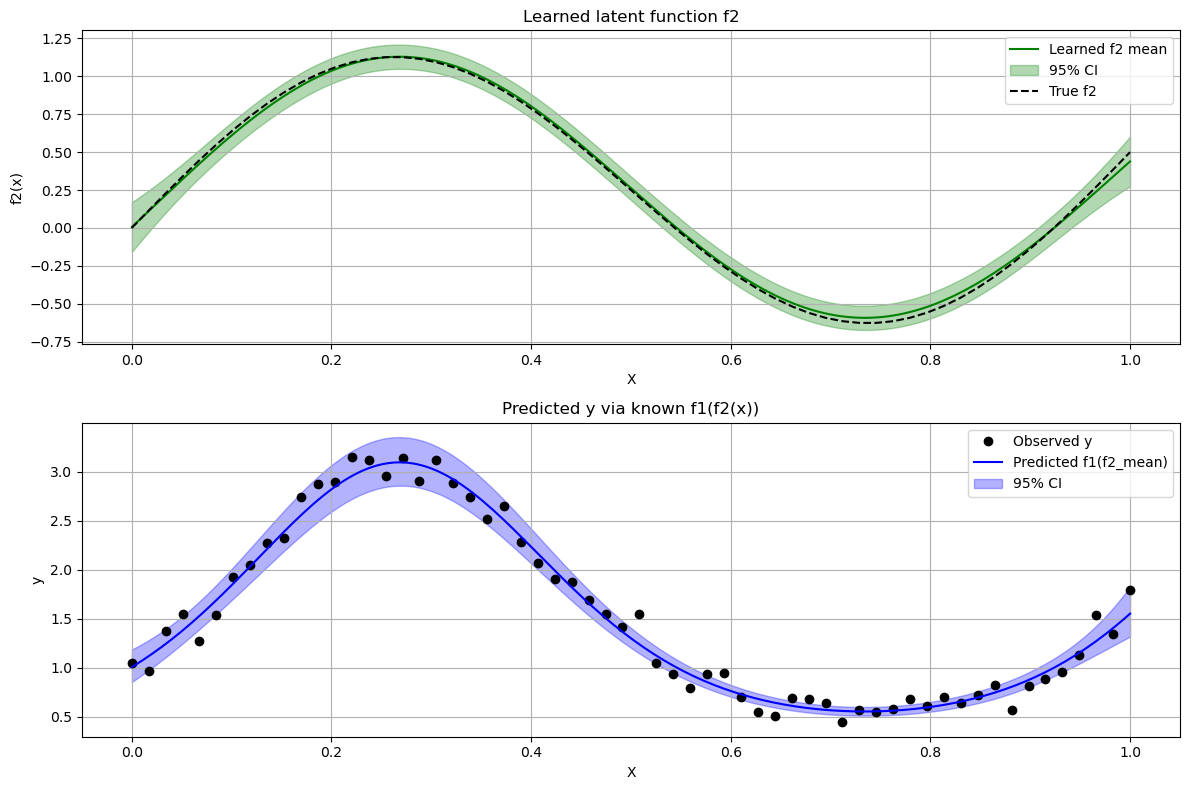

In [26]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)

n = 60
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

# -------------------------
# 2. Invert f1 approximately to get pseudo-observations for f2
# -------------------------
# Note: f1 = exp => f1^{-1} = log
f2_pseudo = np.log(y)  # simple pseudo-observation

# -------------------------
# 3. Fit GP to learn latent f2
# -------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=sigma_y**2)
gp_f2.fit(X, f2_pseudo)

# -------------------------
# 4. Predict latent f2
# -------------------------
X_star = np.linspace(0, 1, 200)[:, None]
f2_mean, f2_std = gp_f2.predict(X_star, return_std=True)
f2_hi = f2_mean + 1.96*f2_std
f2_lo = f2_mean - 1.96*f2_std

# -------------------------
# 5. Predict outer y via f1(f2)
# -------------------------
y_pred = f1(f2_mean)
y_hi = f1(f2_hi)
y_lo = f1(f2_lo)

# -------------------------
# 6. Plot results
# -------------------------
plt.figure(figsize=(12,8))

# Top: latent f2
plt.subplot(2,1,1)
plt.plot(X_star, f2_mean, 'g', label="Learned f2 mean")
plt.fill_between(X_star.ravel(), f2_lo, f2_hi, color='green', alpha=0.3, label="95% CI")
plt.plot(X, f2_true(X), 'k--', label="True f2")
plt.xlabel("X")
plt.ylabel("f2(x)")
plt.title("Learned latent function f2")
plt.legend()
plt.grid(True)

# Bottom: observations / reconstructed y
plt.subplot(2,1,2)
plt.plot(X, y, 'o', color='black', label="Observed y")
plt.plot(X_star, y_pred, 'b', label="Predicted f1(f2_mean)")
plt.fill_between(X_star.ravel(), y_lo, y_hi, color='blue', alpha=0.3, label="95% CI")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Predicted y via known f1(f2(x))")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Hybrid compositional GP -> NN model

GP to learn f2 and NN to learn f1: $y\approx NN(f_2, GP(x))$\
-> Simplified Deep Gaussian Process (DPG): 1st layer probabilistic (GP), 2nd layer deterministic (NN)\
-> learn latent f2 using a GP
-> use the mean prediction as input for the NN

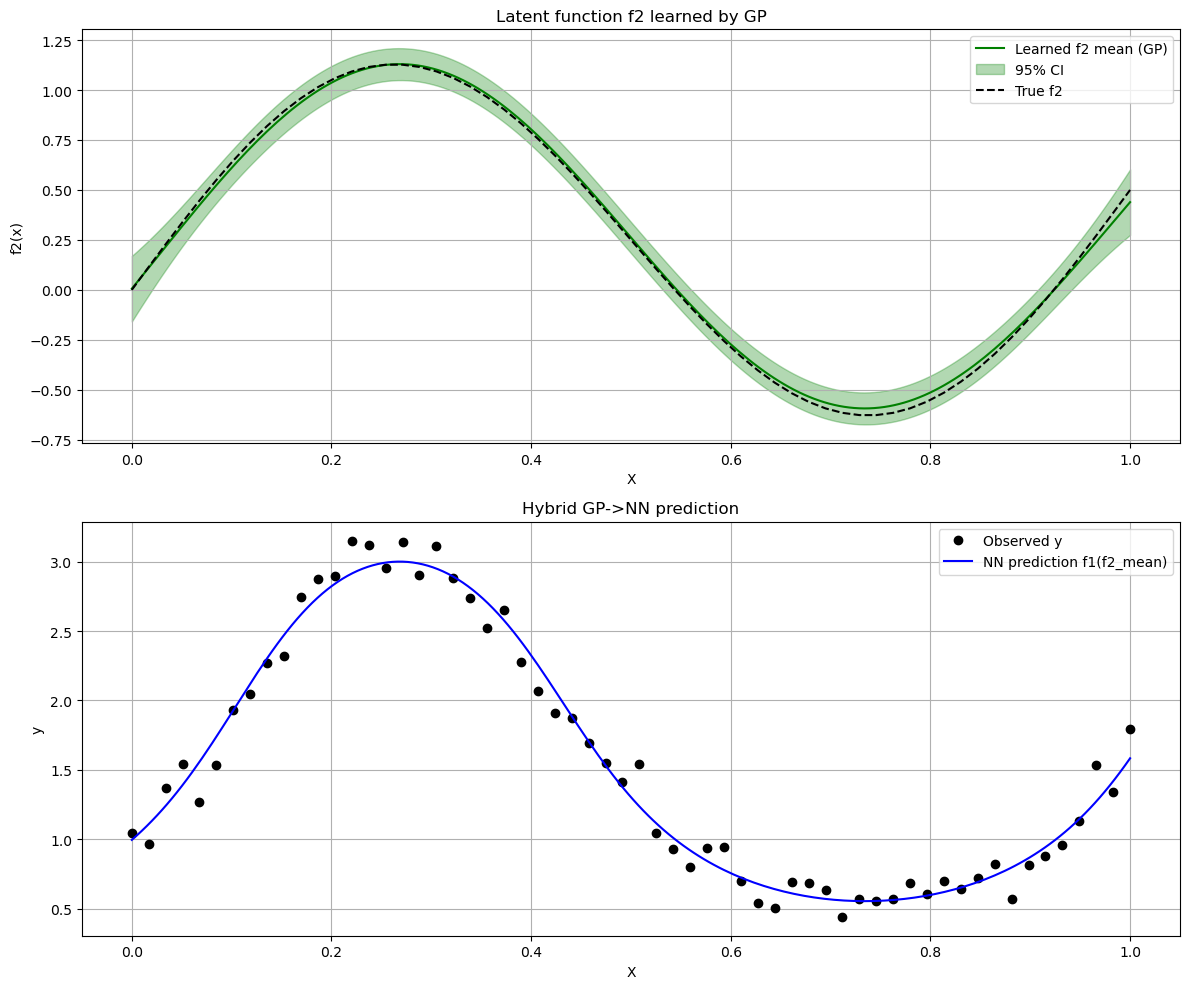

In [ ]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)   # known outer function

n = 60
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

# -------------------------
# 2. Fit GP to learn latent f2
# -------------------------
# Use pseudo-inversion for simplicity
f2_pseudo = np.log(y)

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=sigma_y**2)
gp_f2.fit(X, f2_pseudo)

# Predict latent f2 at dense inputs
X_star = np.linspace(0, 1, 200)[:, None]
f2_mean, f2_std = gp_f2.predict(X_star, return_std=True)

# -------------------------
# 3. Neural network for f1(f2)
# -------------------------
# Use GP predictions at training points X (not X_star)
f2_train_mean, _ = gp_f2.predict(X, return_std=True)
f2_tensor = torch.tensor(f2_train_mean.reshape(-1,1), dtype=torch.float32)
y_tensor  = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

# Define a tiny NN
class TinyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TinyNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(f2_tensor)
    loss = loss_fn(pred, y_tensor)
    loss.backward()
    optimizer.step()

# NN predictions
y_pred_nn = model(f2_tensor).detach().numpy()

f2_star_tensor = torch.tensor(f2_mean.reshape(-1,1), dtype=torch.float32)
y_pred_nn_star = model(f2_star_tensor).detach().numpy()

# -------------------------
# 4. Plot results
# -------------------------
plt.figure(figsize=(12,10))

# Top: latent f2
plt.subplot(2,1,1)
plt.plot(X_star, f2_mean, 'g', label="Learned f2 mean (GP)")
plt.fill_between(X_star.ravel(), f2_mean-1.96*f2_std, f2_mean+1.96*f2_std, color='green', alpha=0.3, label="95% CI")
plt.plot(X, f2_true(X), 'k--', label="True f2")
plt.xlabel("X")
plt.ylabel("f2(x)")
plt.title("Latent function f2 learned by GP")
plt.legend()
plt.grid(True)

# Bottom: predicted y via NN on f2
plt.subplot(2,1,2)
plt.plot(X, y, 'o', color='black', label="Observed y")
plt.plot(X_star, y_pred_nn_star, 'b', label="NN prediction f1(f2_mean)")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Hybrid GP->NN prediction")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Hybrid GP -> NN (smae as before), but now with uncertainty propagation

Draw n indep samples of f2 from the GP posterior\
MC uncertainty propagation

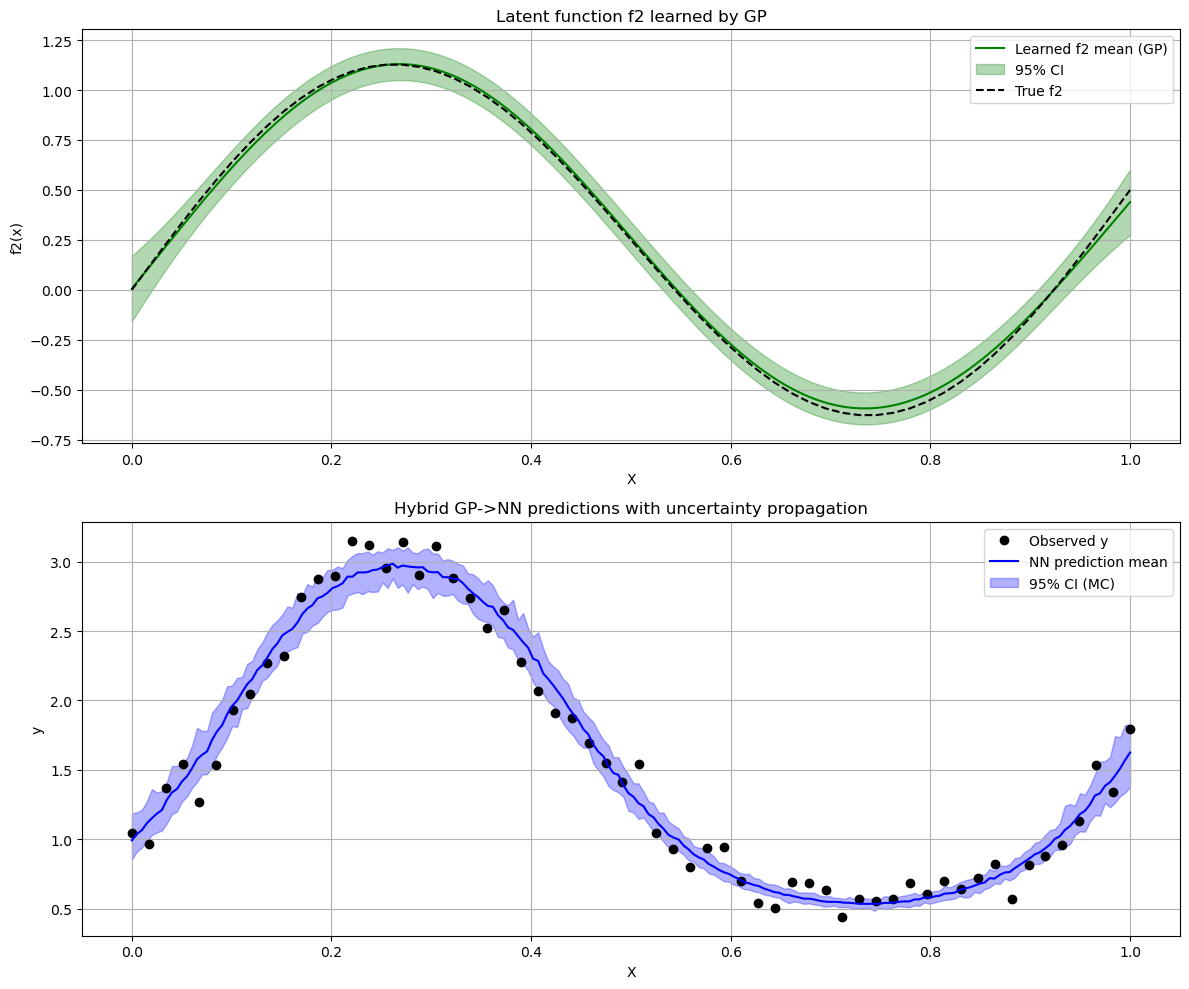

In [13]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)   # known outer function

n = 60
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

# -------------------------
# 2. Fit GP to learn latent f2
# -------------------------
f2_pseudo = np.log(y)

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=sigma_y**2)
gp_f2.fit(X, f2_pseudo)

X_star = np.linspace(0, 1, 200)[:, None]
f2_mean, f2_std = gp_f2.predict(X_star, return_std=True)

# -------------------------
# 3. Neural network for f1(f2)
# -------------------------
# Use original training points (GP mean) for NN input
# Use GP predictions at training points X (not X_star)
f2_train_mean, _ = gp_f2.predict(X, return_std=True)
f2_tensor = torch.tensor(f2_train_mean.reshape(-1,1), dtype=torch.float32)
y_tensor  = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

class TinyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TinyNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train NN
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(f2_tensor)
    loss = loss_fn(pred, y_tensor)
    loss.backward()
    optimizer.step()

# -------------------------
# 4. Uncertainty propagation via Monte Carlo
# -------------------------
n_samples = 50
y_samples = []

for i in range(n_samples):
    # Sample f2 from GP posterior
    f2_sample = rng.normal(f2_mean, f2_std)
    f2_sample_tensor = torch.tensor(f2_sample.reshape(-1,1), dtype=torch.float32)
    # Pass through NN
    y_nn_sample = model(f2_sample_tensor).detach().numpy().ravel()
    y_samples.append(y_nn_sample)

y_samples = np.array(y_samples)
y_mean_mc = y_samples.mean(axis=0)
y_lo_mc, y_hi_mc = np.percentile(y_samples, [2.5, 97.5], axis=0)

# -------------------------
# 5. Plot results
# -------------------------
plt.figure(figsize=(12,10))

# Top: latent f2
plt.subplot(2,1,1)
plt.plot(X_star, f2_mean, 'g', label="Learned f2 mean (GP)")
plt.fill_between(X_star.ravel(), f2_mean-1.96*f2_std, f2_mean+1.96*f2_std, color='green', alpha=0.3, label="95% CI")
plt.plot(X, f2_true(X), 'k--', label="True f2")
plt.xlabel("X")
plt.ylabel("f2(x)")
plt.title("Latent function f2 learned by GP")
plt.legend()
plt.grid(True)

# Bottom: y predictions with propagated uncertainty
plt.subplot(2,1,2)
plt.plot(X, y, 'o', color='black', label="Observed y")
plt.plot(X_star, y_mean_mc, 'b', label="NN prediction mean")
plt.fill_between(X_star.ravel(), y_lo_mc, y_hi_mc, color='blue', alpha=0.3, label="95% CI (MC)")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Hybrid GP->NN predictions with uncertainty propagation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
